#### Preprocessing Charging Sessions Dataset

First, we import important libraries needed for the following tasks.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

We import the necessary dataset (charging sessions of EVs) with the data of charging garages in Los Angeles.

In [102]:
data_raw = pd.read_csv("data/charging_sessions.csv")

Getting a first sight of the data by displaying the first 5 observations.

In [103]:
data_raw.head(5)

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [104]:
num_rows, num_columns = data_raw.shape
print(f"rows: {num_rows}, columns: {num_columns}")

rows: 66450, columns: 13


The data in the dataset contains 66.450 observation over 13 different variables. Next, we drop duplicates and have closer look at the different datatypes.

In [105]:
columns = [
    'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered',
    'sessionID', 'siteID', 'spaceID', 'stationID', 'timezone', 'userID', 'userInputs'
]
data_unique = data_raw.drop_duplicates(subset=columns)

In [106]:
dtypes_data = data_unique.dtypes.reset_index()
dtypes_data.columns = ['Row', 'Datetype']
print(dtypes_data)

                 Row Datetype
0         Unnamed: 0    int64
1                 id   object
2     connectionTime   object
3     disconnectTime   object
4   doneChargingTime   object
5       kWhDelivered  float64
6          sessionID   object
7             siteID    int64
8            spaceID   object
9          stationID   object
10          timezone   object
11            userID  float64
12        userInputs   object


We convert all the data into corresponding data types so that we can use them in the further analysis. 
The time-related data is given in the UTC time zone, but the garages are in Los Angeles. In order to obtain accurate information about the timestamps, the data must therefore be converted to the corresponding time zone (LosAngeles).  

In [107]:
data_unique['id'] = data_unique['id'].astype("string")
data_unique['connectionTime'] = pd.to_datetime(data_unique['connectionTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['disconnectTime'] = pd.to_datetime(data_unique['disconnectTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['doneChargingTime'] = pd.to_datetime(data_unique['doneChargingTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['siteID'] = data_unique['siteID'].astype("int")
data_unique['spaceID'] = data_unique['spaceID'].astype("string")
data_unique['stationID'] = data_unique['stationID'].astype("string")
data_unique['timezone'] = data_unique['timezone'].astype("string")
data_unique['userID'] = data_unique['userID'].astype("string")
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['userInputs'] = data_unique['userInputs'].apply(lambda x: list(x) if isinstance(x, list) else [x])

The `unnamed` column is presumably an index from the riginal DataFrame and gets transferred into a column when reading the CSV-file. Since our data contains a unique ID for each entry, the unnamed-numbering is not needed and can be deleted. We also delete the id of the respective session (`sessionID`) and loading processes (`id`) because we consider these to be irrelevant for the analysis. Every user has an id and so does every station, so that the individual loading processes can be assigned.

In [108]:
data_unique = data_unique.drop('Unnamed: 0', axis=1)
data_unique = data_unique.drop('sessionID', axis=1)
data_unique = data_unique.drop('id', axis=1)

print(data_unique.dtypes)

connectionTime      datetime64[ns]
disconnectTime      datetime64[ns]
doneChargingTime    datetime64[ns]
kWhDelivered               float64
siteID                       int64
spaceID             string[python]
stationID           string[python]
timezone            string[python]
userID              string[python]
userInputs                  object
dtype: object


In [109]:
print(data_unique.info())

<class 'pandas.core.frame.DataFrame'>
Index: 65037 entries, 0 to 65036
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   connectionTime    65037 non-null  datetime64[ns]
 1   disconnectTime    65037 non-null  datetime64[ns]
 2   doneChargingTime  60950 non-null  datetime64[ns]
 3   kWhDelivered      65037 non-null  float64       
 4   siteID            65037 non-null  int64         
 5   spaceID           65037 non-null  string        
 6   stationID         65037 non-null  string        
 7   timezone          65037 non-null  string        
 8   userID            47822 non-null  string        
 9   userInputs        65037 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(1), string(4)
memory usage: 5.5+ MB
None


In [110]:
missing_values_count = data_unique.isnull().sum()
print(missing_values_count)

connectionTime          0
disconnectTime          0
doneChargingTime     4087
kWhDelivered            0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17215
userInputs              0
dtype: int64


By looking at the dataframe, you can see that `doneChargingTime` and `userID` have missing values.  

The missing values in userID can be explained by the fact that not every garage user is registered; therefore, some accounts are naturally absent. However, the missing entries in `doneChargingTime` appear unusual.

In [111]:
# create Table with missing values in doneChargingTime
miss_doneChargingTime = data_unique[data_unique['doneChargingTime'].isna()]

Upon closer analysis of the missing entries for the charging time (`miss_doneChargingTime`), we found that all of them have normal values for the attribute `kWhDelivered`, indicating that current flow was indeed present.

(Removing this data from the dataframe would imply that the charging stations were free at those times, which is inaccurate and would skew predictions. Therefore, we decided to retain this data for now and, if necessary, exclude it during model training and predictions about parking space utilization after charging is complete.)

We calculate the the percentage of missing (NaN) values for each column.

In [112]:
data_unique.isnull().mean() * 100

connectionTime       0.000000
disconnectTime       0.000000
doneChargingTime     6.284115
kWhDelivered         0.000000
siteID               0.000000
spaceID              0.000000
stationID            0.000000
timezone             0.000000
userID              26.469548
userInputs           0.000000
dtype: float64

Let's calculate the percentage of data left after removing the missing values.

In [113]:
len(data_unique['doneChargingTime'].dropna())/len(data_unique['doneChargingTime']) * 100

93.71588480403462

After removing the columns with missing values, around 94% of the data is still intact which seems to be sufficient. So we first create a copy of the data set in order to then remove the missing values from ‘doneChargingTime’.

In [114]:
# Create a copy of the data before dropping NA values from doneChaargingTime
data_with_NA = data_unique.copy()

# Drop NA from doneChargingTime
data_unique.dropna(subset=['doneChargingTime'], inplace=True)

print(data_unique['doneChargingTime'].isnull().sum())

0


We can explore how the data is distributed in each column before and after removing null values by plotting histograms. This approach will enable us to compare the distribution trends in both scenarios.

<Axes: >

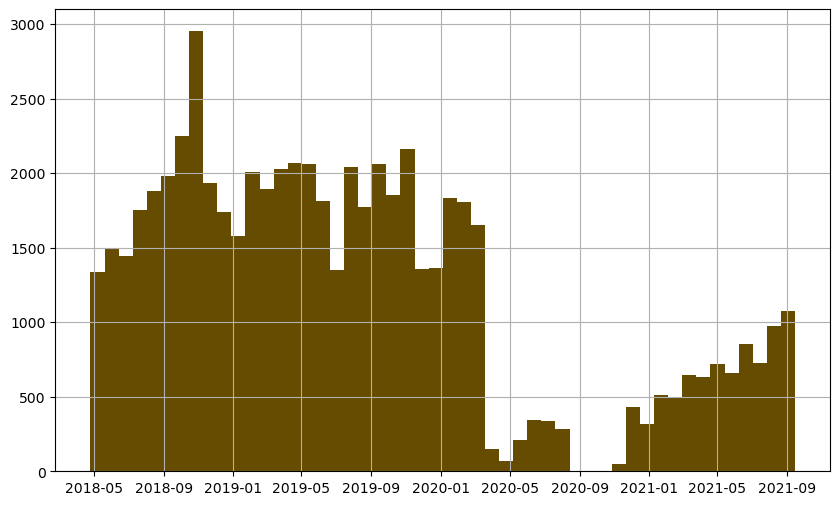

In [115]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

data_with_NA['doneChargingTime'].hist(bins=50, ax=ax, density=False, color='red')

data_unique['doneChargingTime'].hist(bins=50, ax=ax, density=False, color='green', alpha=0.6)


By comparing the histograms of the 'doneChargingTime' column before and after removing the null values, it is clear that the data distribution stays consistent. The overlapping histograms show that there is no major change in the distribution pattern after null values were removed.

In [116]:
# split the dataset in two different. One for the station with siteID 1 and one for the station with the siteID 2 for further analysis
data_1 = data_unique[data_unique['siteID']==1]
data_2 = data_unique[data_unique['siteID']==2]

#### Preprocessing Weather Burbank Dataset

The weather dataset is also imported and duplicates are removed. Although there are none, we have carried out this step to be on the safe side.  
The data was converted to the corresponding data types and the time was adjusted to the los-angeles time zone again.  
There is some missing data in this data set for the `temperature` and the `cloud_cover`. However, these are difficult to reproduce and are therefore deleted from the data set.

In [117]:
weather_raw=pd.read_csv("data/weather_burbank_airport.csv")

# delete duplicates
columns = [
    'city', 'timestamp', 'temperature', 'cloud_cover',
    'cloud_cover_description', 'pressure', 'windspeed', 'precipitation', 'felt_temperature'
]
weather_unique = weather_raw.drop_duplicates(subset=columns)

#Transform to correct Data Types
weather_unique['city']=weather_raw['city'].astype('string')
weather_unique['timestamp'] = pd.to_datetime(weather_raw['timestamp'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
weather_unique['cloud_cover_description']=weather_raw['cloud_cover_description'].astype('string')

# drop with missing values
weather_unique = weather_unique.dropna(subset=['temperature'])
weather_unique = weather_unique.dropna(subset=['cloud_cover'])

print(weather_unique.dtypes)

city                       string[python]
timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description    string[python]
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object


#### Site detection 
Find out which site is the public one at a university and which one is private and only open to employees of a company.


Ideas:
- **time distribution**: time of day usage patterns; what about weekends?
- private site users may have a larger **gap between doneCharging and disconnectTime** because they leave vehicles plugged in through workday
- **usage frequency** - public busier whith higher session counts per day
- **session duration**: public hubs have shorter session durations
- **user diversity**: where are more registrated users?; unique userID counts - private can only be same userIDs (limited), public can have high diversity
- **session clustering**: public more random sessions throughout day and week, private clustering with typical business schedules

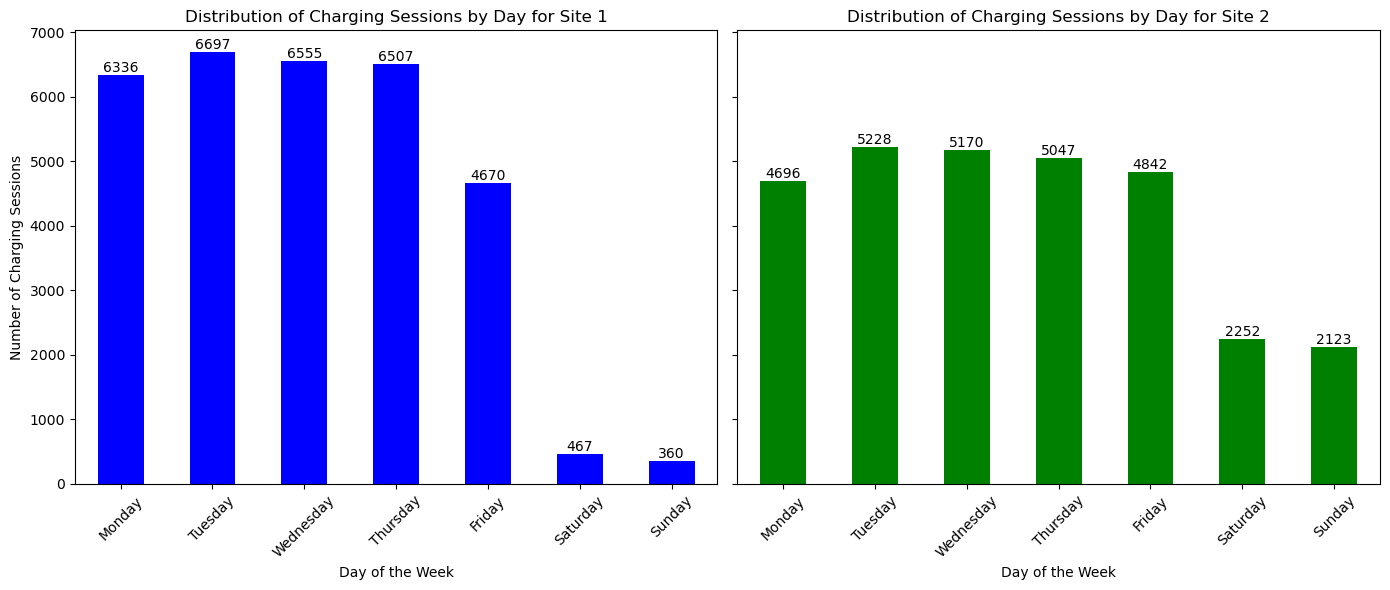

In [118]:
pd.options.mode.chained_assignment = None

data_1['dayOfWeek'] = data_1['connectionTime'].dt.day_of_week
day_of_week_counts_site1 = data_1['dayOfWeek'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts_site1.index = days
#print(day_of_week_counts)

data_2['dayOfWeek'] = data_2['connectionTime'].dt.day_of_week
day_of_week_counts_site2 = data_2['dayOfWeek'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts_site2.index = days

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Site 1
day_of_week_counts_site1.plot(kind='bar', color='blue', ax=axes[0])
axes[0].set_title('Distribution of Charging Sessions by Day for Site 1')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Number of Charging Sessions')
axes[0].set_xticklabels(days, rotation=45)

# Annotate the exact count on top of each bar for Site 1
for index, value in enumerate(day_of_week_counts_site1):
    axes[0].text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

# Plot for Site 2
day_of_week_counts_site2.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_title('Distribution of Charging Sessions by Day for Site 2')
axes[1].set_xlabel('Day of the Week')
axes[1].set_xticklabels(days, rotation=45)

# Annotate the exact count on top of each bar for Site 2
for index, value in enumerate(day_of_week_counts_site2):
    axes[1].text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

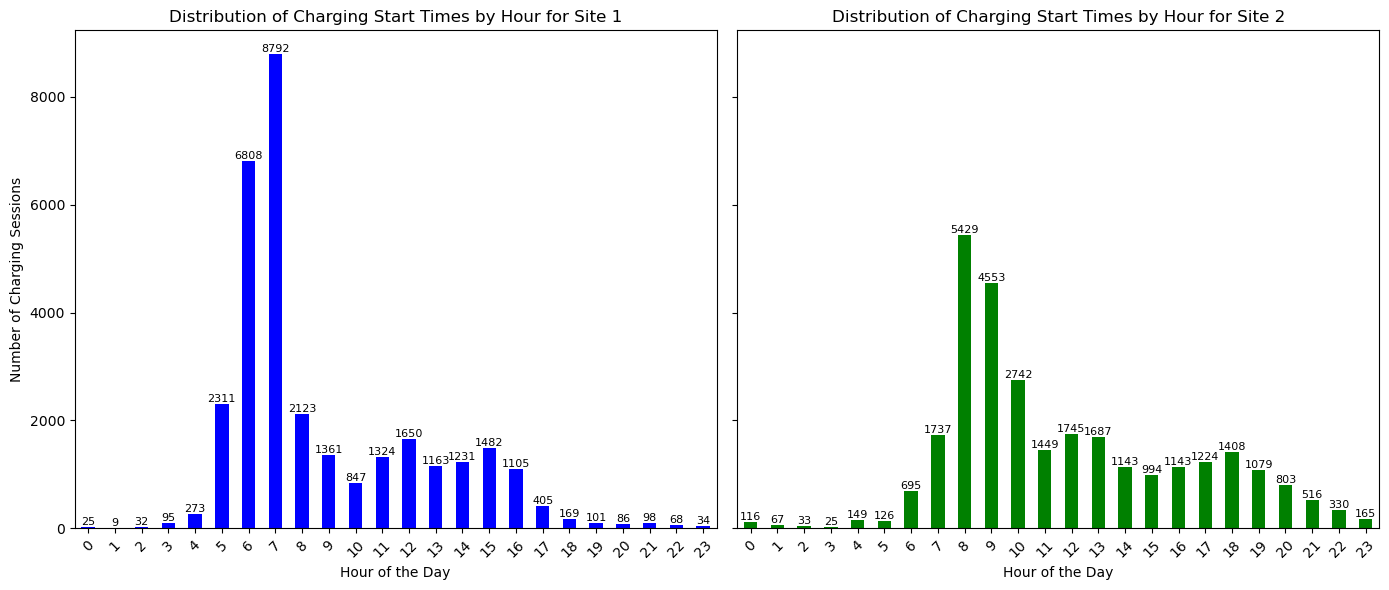

In [119]:
pd.options.mode.chained_assignment = None
data_1['startHour'] = data_1['connectionTime'].dt.hour
start_hour_counts_1 = data_1['startHour'].value_counts().sort_index()

data_2['startHour'] = data_2['connectionTime'].dt.hour
start_hour_counts_2 = data_2['startHour'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

start_hour_counts_1.plot(kind='bar', color='blue', ax=axes[0])
axes[0].set_title('Distribution of Charging Start Times by Hour for Site 1')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Charging Sessions')
axes[0].set_xticks(range(24))
axes[0].set_xticklabels(range(24), rotation=45)

# Annotate the exact count on top of each bar for Site 1
for index, value in enumerate(start_hour_counts_1):
    axes[0].text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=8)

# Plot for Site 2
start_hour_counts_2.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_title('Distribution of Charging Start Times by Hour for Site 2')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_xticks(range(24))
axes[1].set_xticklabels(range(24), rotation=45)

# Annotate the exact count on top of each bar for Site 2
for index, value in enumerate(start_hour_counts_2):
    axes[1].text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=8)

# Show the plot
plt.tight_layout()

session duration

std_session_duration() = standard deviation from mean


In [120]:
data_1['session_duration'] = (data_1['disconnectTime'] - data_1['connectionTime']).dt.total_seconds() /3600 
data_1['charging_duration'] = (data_1['doneChargingTime'] - data_1['connectionTime']).dt.total_seconds() /3600 

site_1_summary = {
    'site_id': 'Site 1',
    'avg_session_duration': data_1['session_duration'].mean(),
    'median_session_duration': data_1['session_duration'].median(),
    'std_session_duration': data_1['session_duration'].std(),
    'total_session_duration': data_1['session_duration'].sum(),
    'session_count': len(data_1),
    'avg_charging_duration': data_1['charging_duration'].mean(),
    'avg_kWh_delivered': data_1['kWhDelivered'].mean(),
    'total_kWh_delivered': data_1['kWhDelivered'].sum()
}

data_2['session_duration'] = (data_2['disconnectTime'] - data_2['connectionTime']).dt.total_seconds() /3600 
data_2['charging_duration'] = (data_2['doneChargingTime'] - data_2['connectionTime']).dt.total_seconds() /3600 

site_2_summary = {
    'site_id': 'Site 1',
    'avg_session_duration': data_2['session_duration'].mean(),
    'median_session_duration': data_2['session_duration'].median(),
    'std_session_duration': data_2['session_duration'].std(),
    'total_session_duration': data_2['session_duration'].sum(),
    'session_count': len(data_2),
    'avg_charging_duration': data_2['charging_duration'].mean(),
    'avg_kWh_delivered': data_2['kWhDelivered'].mean(),
    'total_kWh_delivered': data_2['kWhDelivered'].sum()
}

site_comparison = pd.DataFrame([site_1_summary, site_2_summary])
site_comparison.head()


,site_id,avg_session_duration,median_session_duration,std_session_duration,total_session_duration,session_count,avg_charging_duration,avg_kWh_delivered,total_kWh_delivered
0,Site 1,6.871289,7.601806,3.504144,217077.765000,31592,4.032715,14.163597,447456.360717
1,Site 1,5.846978,4.988333,6.043932,171655.583056,29358,2.977746,8.806589,258543.828292


In [121]:
data_1['duration_category'] = pd.cut(
    data_1['session_duration'], 
    bins=[0, 2, 7, 9, float('inf')], 
    labels=['< 3 ', '3 to 6', '6 to 9', '> 9'], 
    right=False
)

data_2['duration_category'] = pd.cut(
    data_2['session_duration'], 
    bins=[0, 2, 7, 9, float('inf')], 
    labels=['< 3 ', '3 to 6', '6 to 9', '> 9'], 
    right=False
)

# Count sessions by duration category for each site
duration_counts_1 = data_1['duration_category'].value_counts().reindex(['< 3 ', '3 to 6', '6 to 9', '> 9'], fill_value=0)
duration_counts_2 = data_2['duration_category'].value_counts().reindex(['< 3 ', '3 to 6', '6 to 9', '> 9'], fill_value=0)


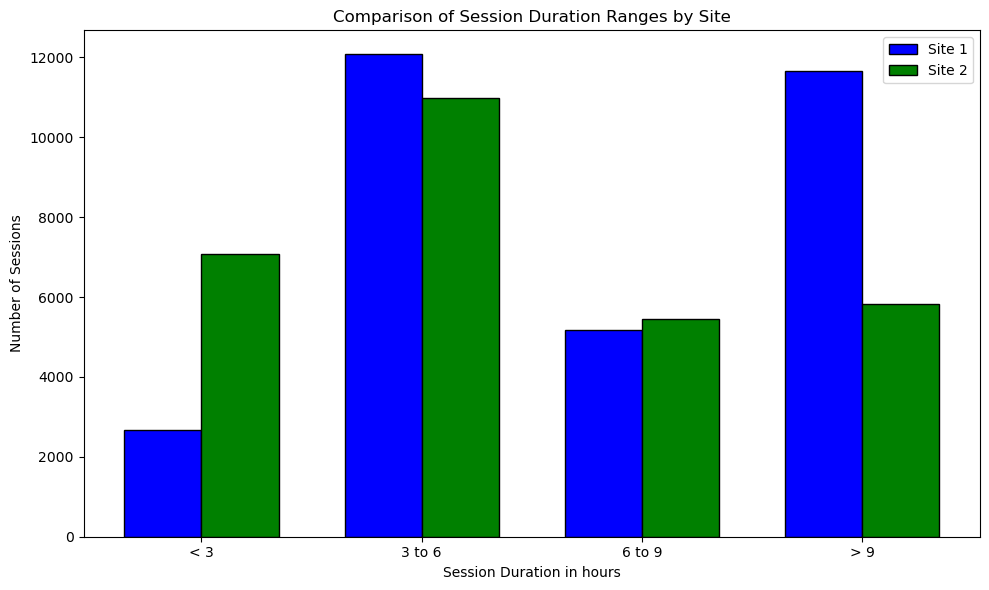

In [122]:
# Creating the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars
bar_width = 0.35

# Define the position of the bars
index = range(len(duration_counts_1))

# Plot the bars for Site 1 and Site 2 next to each other
bar1 = ax.bar(index, duration_counts_1, bar_width, label='Site 1', color='blue', edgecolor='black')
bar2 = ax.bar([i + bar_width for i in index], duration_counts_2, bar_width, label='Site 2', color='green', edgecolor='black')

# Set labels and title
ax.set_xlabel('Session Duration in hours')
ax.set_ylabel('Number of Sessions')
ax.set_title('Comparison of Session Duration Ranges by Site')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['< 3', '3 to 6', '6 to 9', '> 9'])
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
